In [1]:
import sys
sys.path.append('../.')


from utils import *
from Data.DataGenerator import *
from Models.Models_normal import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
from Training.Spike_loss import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [2]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/january_res/mnist/normal/bias_0.0001/mnist_training/try_num3/epoch_120/model.pt', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()



dataset_target_samples = train_samples
dataset_target_labels = train_labels

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [3]:
anal_path = '../../spike_analysis/spikes_epoch_resume2025/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, dataset_target_samples, dataset_target_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
plt.close()
print("---")

---


In [4]:
# data = results_dict['representations'][11]

data = np.array(results_dict['pca_2'][7]).transpose()
data = torch.Tensor(data)

mnist_labels = dataset_target_labels.detach().cpu().numpy()
mnist_data = dataset_target_samples.detach().cpu().numpy().reshape(dataset_target_samples.shape[0], 28 * 28)

class_data_indices = np.where(mnist_labels == 0)[0]
class_data = data[class_data_indices]



points = class_data.clone().detach().cpu().numpy()
# Detect hyperplanes
detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)

# Print results
print(f"Total error: {total_error:.4f}")
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    print(f"Hyperplane {i+1}:")
    print(f"Equation: {' + '.join([f'{c:.4f}x{j+1}' for j, c in enumerate(coef)])} + {intercept:.4f} = 0")
    print(f"Number of inliers: {num_inliers}")
    print(f"Hyperplane error: {hyperplane_error:.4f}")


Total error: 14499.0968
Hyperplane 1:
Equation: -2.4759x1 + -0.8216x2 + -101.2208 = 0
Number of inliers: 435
Hyperplane error: 71.7383
Hyperplane 2:
Equation: -1.0000x1 + 0.2317x2 + 11.4402 = 0
Number of inliers: 210
Hyperplane error: 45.3843
Hyperplane 3:
Equation: -2.5087x1 + -1.0000x2 + -45.5570 = 0
Number of inliers: 172
Hyperplane error: 14.0683
Hyperplane 4:
Equation: -1.0000x1 + -0.2902x2 + 12.1273 = 0
Number of inliers: 108
Hyperplane error: 24.6849
Hyperplane 5:
Equation: -1.0000x1 + 0.2949x2 + -15.7824 = 0
Number of inliers: 101
Hyperplane error: 22.7709
Hyperplane 6:
Equation: -1.0000x1 + 0.2762x2 + -49.5501 = 0
Number of inliers: 96
Hyperplane error: 21.4154
Hyperplane 7:
Equation: 3.2706x1 + -1.0000x2 + 20.4636 = 0
Number of inliers: 24
Hyperplane error: 1.7287


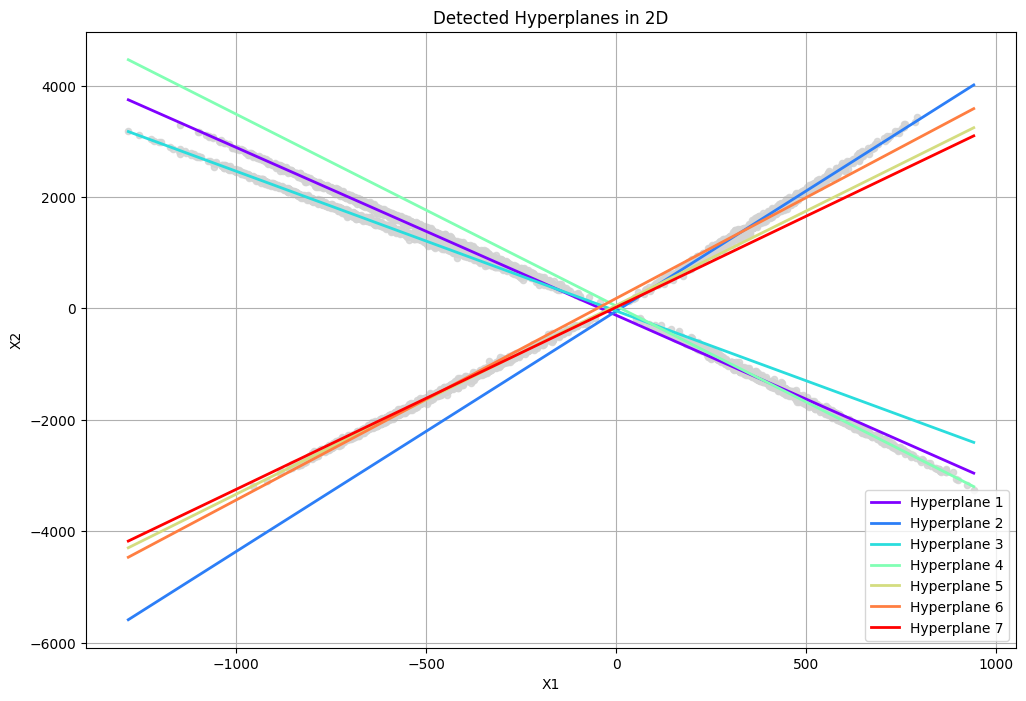

14499.096775823396


In [5]:
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_hyperplanes)))

# Plot all points
plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=20, alpha=0.8)

# Plot assigned points and hyperplanes
for (coef, intercept, _, _), assigned, color in zip(detected_hyperplanes, assigned_points, colors):
    # plt.scatter(assigned[:, 0], assigned[:, 1], c=[color], s=20, alpha=0.7)
    
    # Plot hyperplane (line in 2D)
    x_range = np.array([points[:, 0].min(), points[:, 0].max()])
    y_range = (-coef[0] * x_range - intercept) / coef[1]
    plt.plot(x_range, y_range, c=color, linewidth=2, label=f'Hyperplane {len(plt.gca().lines) + 1}')

# plt.ylim(-200, 200)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Detected Hyperplanes in 2D')
plt.legend()
plt.grid(True)
plt.show()

print(total_error)

In [17]:
def load_model(epoch, model_path_template, arch, device):
    model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)
    model.to(device)
    model_path = model_path_template.format(epoch)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def perform_spike_detection(model, dataset_samples, dataset_labels, device, layer_idx):
    results_dict = fixed_model_batch_analysis(
        model, dataset_samples, dataset_labels, device, f'analyze_layer_{layer_idx}_', 'analyze', plotting=False
    )
    
    mnist_labels = dataset_labels.detach().cpu().numpy()
    mnist_pca_2d = np.array(results_dict['pca_2'][layer_idx]).transpose()
    
    # Debugging: Check PCA shape
    print(f"PCA_2D Shape for Layer {layer_idx}: {mnist_pca_2d.shape}")
    
    num_classes = len(np.unique(mnist_labels))
    spike_assignments_per_class = {}
    
    for class_idx in tqdm(range(num_classes), desc="Detecting spikes for classes"):
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        class_points = mnist_pca_2d[class_data_indices]
        
        # Ensure class_points is 2D
        if class_points.ndim == 1:
            class_points = class_points.reshape(1, -1)
        
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(class_points)
        assignments, _, _ = assign_points_to_hyperplanes(torch.Tensor(class_points), detected_hyperplanes)
        
        spike_assignments_per_class[class_idx] = {
            'class_data_indices': class_data_indices,
            'assignments': assignments,
            'detected_hyperplanes': detected_hyperplanes
        }
    
    return spike_assignments_per_class, results_dict


def spike_tracking_across_epochs(original_epoch, other_epochs, model_path_template, arch, device, dataset_samples, dataset_labels, layer_idx, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    epochs = [original_epoch] + other_epochs
    spike_assignments_all_epochs = {epoch: {} for epoch in epochs}
    pca_results_all_epochs = {epoch: None for epoch in epochs}
    
    for epoch in tqdm(epochs, desc="Processing epochs"):
        model = load_model(epoch, model_path_template, arch, device)
        spike_assignments, results_dict = perform_spike_detection(model, dataset_samples, dataset_labels, device, layer_idx)
        
        # Debugging: Check types and shapes
        print(f"Epoch {epoch}:")
        print(f"  Spike Assignments Type: {type(spike_assignments)}")
        print(f"  Spike Assignments Keys: {spike_assignments.keys()}")
        
        # Assuming 'pca_2' contains 2D PCA results
        pca_layer = results_dict['pca_2'][layer_idx]
        print(f"  PCA Layer {layer_idx} Type: {type(pca_layer)}")
        print(f"  PCA Layer {layer_idx} Shape: {np.array(pca_layer).shape}")
        
        spike_assignments_all_epochs[epoch] = spike_assignments
        pca_results_all_epochs[epoch] = results_dict['pca_2'][layer_idx]
    
    return spike_assignments_all_epochs, pca_results_all_epochs

def plot_spike_tracking(spike_assignments_all_epochs, pca_results_all_epochs, original_epoch, other_epochs, output_dir, layer_idx):
    os.makedirs(output_dir, exist_ok=True)
    epochs = [original_epoch] + other_epochs
    num_classes = len(spike_assignments_all_epochs[original_epoch])

    for class_idx in tqdm(range(num_classes), desc="Plotting classes"):
        # Retrieve spike assignments and class indices for the original epoch
        original_assignments = spike_assignments_all_epochs[original_epoch][class_idx]['assignments']
        original_indices = spike_assignments_all_epochs[original_epoch][class_idx]['class_data_indices']
        
        # Find unique spike labels
        unique_spike_labels = np.unique(original_assignments)
        num_spikes = len(unique_spike_labels)
        
        print(f"\nClass {class_idx}:")
        print(f"  Number of Detected Spikes: {num_spikes}")
        print(f"  Number of Epochs: {len(epochs)}")
        
        # Initialize list to hold indices for each unique spike
        spikes_indices = []
        
        for unique_spike_label in unique_spike_labels:
            # Find all data points assigned to the current unique spike
            spike_mask = (original_assignments == unique_spike_label)
            spike_data_indices = original_indices[spike_mask].tolist()
            spikes_indices.append(spike_data_indices)
        
        print(f"  Spike Indices: {spikes_indices}")
        print(f"  Figure Size: {(4 * len(epochs), 4 * num_spikes)}")
        
        if num_spikes == 0:
            print(f"  No spikes detected for class {class_idx}. Skipping plot.")
            continue
        
        # Create subplots: rows=num_spikes, columns=len(epochs)
        fig, axes = plt.subplots(num_spikes, len(epochs), figsize=(4 * len(epochs), 4 * num_spikes), squeeze=False)
        
        # Iterate over each spike
        for spike_idx, spike_data_indices in enumerate(spikes_indices):
            # Iterate over each epoch
            for col_idx, epoch in enumerate(epochs):
                ax = axes[spike_idx, col_idx]
                pca_2d = np.array(pca_results_all_epochs[epoch]).transpose()
                
                # Retrieve class-specific PCA data
                class_indices = spike_assignments_all_epochs[epoch][class_idx]['class_data_indices']
                class_pca_2d = pca_2d[class_indices]
                
                # Ensure PCA data is 2D
                if class_pca_2d.ndim == 1:
                    class_pca_2d = class_pca_2d.reshape(-1, 1)
                    print(f"    Reshaped class_pca_2d to 2D for epoch {epoch}, class {class_idx}")
                
                # Plot all data points
                ax.scatter(class_pca_2d[:, 0], class_pca_2d[:, 1], alpha=0.2, color='gray', label='All Data')
                
                # Find the relative indices within class_pca_2d that correspond to spike_data_indices
                # This is necessary because class_pca_2d is a subset of the entire dataset
                relative_indices = []
                for idx in spike_data_indices:
                    # Find the position of idx within class_indices
                    relative_pos = np.where(class_indices == idx)[0]
                    if len(relative_pos) > 0:
                        relative_indices.append(relative_pos[0])
                    else:
                        print(f"      Warning: Index {idx} not found in class_indices for epoch {epoch}, class {class_idx}")
                
                if relative_indices:
                    selected_data = class_pca_2d[relative_indices]
                    
                    # Ensure selected_data is 2D
                    if selected_data.ndim == 1:
                        selected_data = selected_data.reshape(1, -1)
                        print(f"      Reshaped selected_data to 2D for spike {spike_idx} in epoch {epoch}")
                    
                    # Highlight spikes
                    if epoch == original_epoch:
                        ax.scatter(selected_data[:, 0], selected_data[:, 1], color='red', marker='+', s=50, label='Original Spike')
                    else:
                        ax.scatter(selected_data[:, 0], selected_data[:, 1], color='blue', marker='x', s=50, label=f'Epoch {epoch}')
                
                # Set plot titles and labels
                ax.set_title(f'Epoch {epoch}')
                ax.set_xlabel('PC1')
                ax.set_ylabel('PC2')
                
                # Add legend only to the first subplot of each row
                if spike_idx == 0 and col_idx == 0:
                    ax.legend()
        
        # Set the overall title and layout
        plt.suptitle(f'Spike Tracking for Class {class_idx} Across Epochs (Layer {layer_idx})', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the figure
        save_path = os.path.join(output_dir, f'spike_tracking_class_{class_idx}_layer_{layer_idx}.pdf')
        plt.savefig(save_path)
        plt.close(fig)
        print(f'  Spike tracking plot for class {class_idx} saved to {save_path}')


In [16]:
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model_path_template = '/home/mila/m/mehrab.hamidi/scratch/training_res/january_res/mnist/normal/bias_0.0001/mnist_training/try_num3/epoch_{}/model.pt'

_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()
dataset_target_samples = train_samples
dataset_target_labels = train_labels

original_epoch = 120
other_epochs = [1, 2, 3, 10, 20, 40, 50, 100, 150, 180, 200]
layer_idx = 6
output_dir_analysis = '../../spike_analysis/spike_tracking_across_epochs2025/'
output_dir_plots = os.path.join(output_dir_analysis, f'plots_{layer_idx}')

os.makedirs(output_dir_analysis, exist_ok=True)
os.makedirs(output_dir_plots, exist_ok=True)

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [45]:
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model_path_template = '/home/mila/m/mehrab.hamidi/scratch/training_res/january_res/mnist/normal/bias_0.0001/mnist_training/try_num3/epoch_{}/model.pt'

_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()
dataset_target_samples = train_samples
dataset_target_labels = train_labels

original_epoch = 120
other_epochs = [1, 2, 3, 10, 20, 40, 50, 100, 150, 180, 200]
layer_idx = 6
output_dir_analysis = '../../spike_analysis/spike_tracking_across_epochs2025/'
output_dir_plots = os.path.join(output_dir_analysis, f'plots_{layer_idx}')

os.makedirs(output_dir_analysis, exist_ok=True)
os.makedirs(output_dir_plots, exist_ok=True)

spike_assignments_all_epochs, pca_results_all_epochs = spike_tracking_across_epochs(
    original_epoch=original_epoch,
    other_epochs=other_epochs,
    model_path_template=model_path_template,
    arch=arch,
    device=device,
    dataset_samples=dataset_target_samples,
    dataset_labels=dataset_target_labels,
    layer_idx=layer_idx,
    output_dir=output_dir_analysis
)

# Save the results to a file
analysis_results = {
    'spike_assignments_all_epochs': spike_assignments_all_epochs,
    'pca_results_all_epochs': pca_results_all_epochs
}

save_path = os.path.join(output_dir_analysis, 'analysis_results.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(analysis_results, f)


Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


Processing epochs:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_

PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:   8%|▊         | 1/12 [01:54<21:03, 114.86s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

Epoch 120:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  17%|█▋        | 2/12 [02:59<14:10, 85.04s/it] /tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

Epoch 1:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  25%|██▌       | 3/12 [04:09<11:47, 78.60s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 2:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  33%|███▎      | 4/12 [05:01<09:01, 67.72s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 3:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  42%|████▏     | 5/12 [06:05<07:45, 66.49s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 10:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  50%|█████     | 6/12 [06:55<06:05, 60.86s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 20:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  58%|█████▊    | 7/12 [08:05<05:18, 63.79s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 40:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  67%|██████▋   | 8/12 [09:48<05:05, 76.42s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 50:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  75%|███████▌  | 9/12 [11:50<04:32, 90.72s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Epoch 100:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  83%|████████▎ | 10/12 [14:04<03:27, 103.93s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.l

Epoch 150:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs:  92%|█████████▏| 11/12 [16:20<01:53, 113.89s/it]/tmp/ipykernel_3799560/2288139695.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.l

Epoch 180:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)
PCA_2D Shape for Layer 6: (50000, 2)


Processing epochs: 100%|██████████| 12/12 [18:39<00:00, 93.25s/it] 


Epoch 200:
  Spike Assignments Type: <class 'dict'>
  Spike Assignments Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  PCA Layer 6 Type: <class 'tuple'>
  PCA Layer 6 Shape: (2, 50000)


In [12]:
file = open("../../spike_analysis/spike_tracking_across_epochs/analysis_results.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [26]:
spike_assignments_all_epochs = object_file['spike_assignments_all_epochs']
pca_results_all_epochs = object_file['pca_results_all_epochs']

In [27]:
plot_spike_tracking(
    spike_assignments_all_epochs,
    pca_results_all_epochs,
    original_epoch,
    other_epochs,
    output_dir_plots,
    layer_idx
)

Plotting classes:   0%|          | 0/10 [00:00<?, ?it/s]


Class 0:
  Number of Detected Spikes: 7
  Number of Epochs: 12
  Spike Indices: [[2718, 10005, 10010, 10022, 10025, 10026, 10045, 10069, 10071, 10080, 10083, 10107, 10119, 10120, 10121, 10128, 10140, 10167, 10168, 10176, 10188, 10195, 10203, 10204, 10221, 10230, 10237, 10242, 10254, 10261, 10276, 10283, 10323, 10326, 10334, 10340, 10343, 10348, 10352, 10363, 10366, 10372, 10380, 10407, 10439, 10456, 10469, 10471, 10479, 10488, 10505, 10523, 10542, 10563, 10564, 10579, 10599, 10604, 10625, 10645, 10664, 10689, 10691, 10700, 10705, 10732, 10755, 10773, 10781, 10801, 10806, 10821, 10840, 10844, 10849, 10859, 10874, 10909, 10914, 10916, 10919, 10938, 10974, 10975, 10992, 11014, 11019, 11026, 11027, 11029, 11036, 11041, 11045, 11052, 11060, 11071, 11072, 11077, 11091, 11105, 11116, 11133, 11162, 11172, 11187, 11231, 11240, 11267, 11269, 11281, 11295, 11304, 11315, 11318, 11320, 11330, 11335, 11340, 11354, 11379, 11409, 11422, 11429, 11451, 11453, 11462, 11501, 11514, 11526, 11532, 11541, 1

Plotting classes:  10%|█         | 1/10 [00:20<03:02, 20.26s/it]

  Spike tracking plot for class 0 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_0_layer_6.pdf

Class 1:
  Number of Detected Spikes: 10
  Number of Epochs: 12
  Spike Indices: [[3, 14, 23, 40, 67, 78, 99, 102, 112, 113, 124, 128, 134, 174, 177, 201, 205, 224, 276, 315, 351, 357, 358, 397, 416, 447, 450, 466, 470, 475, 491, 492, 508, 535, 553, 556, 573, 587, 593, 604, 609, 618, 676, 691, 710, 711, 747, 779, 780, 783, 821, 838, 871, 919, 941, 951, 959, 961, 978, 993, 1003, 1031, 1044, 1051, 1052, 1069, 1080, 1081, 1095, 1123, 1148, 1174, 1192, 1211, 1243, 1252, 1259, 1277, 1287, 1293, 1321, 1331, 1365, 1369, 1375, 1394, 1405, 1445, 1450, 1463, 1472, 1497, 1521, 1527, 1528, 1579, 1607, 1627, 1640, 1681, 1703, 1716, 1717, 1787, 1815, 1816, 1839, 1859, 1879, 1909, 1915, 1977, 1989, 2008, 2039, 2094, 2136, 2198, 2202, 2227, 2255, 2301, 2318, 2326, 2335, 2355, 2362, 2375, 2393, 2415, 2448, 2495, 2497, 2505, 2530, 2547, 2552, 2563, 2583, 2604, 2663

Plotting classes:  20%|██        | 2/10 [00:49<03:23, 25.43s/it]

  Spike tracking plot for class 1 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_1_layer_6.pdf

Class 2:
  Number of Detected Spikes: 3
  Number of Epochs: 12
  Spike Indices: [[178, 391, 584, 674, 844, 866, 1010, 1124, 1165, 1330, 1444, 1573, 1896, 2892, 3102, 3362, 3390, 3470, 3980, 4028, 4183, 4241, 4428, 4476, 4646, 4935, 5065, 5095, 5103, 5166, 5216, 5247, 5258, 6044, 6344, 6466, 6480, 6839, 6944, 7029, 7140, 7146, 7337, 7344, 7528, 7695, 7719, 7732, 7760, 8097, 8154, 8211, 8226, 8480, 8490, 8552, 8613, 8853, 9098, 9625, 9748, 9830, 9912, 9972, 10317, 10514, 10920, 11346, 11420, 11648, 12424, 12808, 12815, 12823, 12931, 12985, 13031, 13061, 13121, 13735, 13928, 13952, 14084, 14124, 14357, 14373, 14776, 15278, 15434, 16033, 16662, 17039, 17241, 17263, 17663, 18386, 18776, 18900, 19053, 19463, 19502, 19519, 19524, 19808, 20007, 20021, 20022, 20028, 20029, 20042, 20055, 20065, 20071, 20077, 20078, 20100, 20145, 20160, 20165, 20179, 20224, 

Plotting classes:  30%|███       | 3/10 [00:58<02:06, 18.14s/it]

  Spike tracking plot for class 2 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_2_layer_6.pdf

Class 3:
  Number of Detected Spikes: 7
  Number of Epochs: 12
  Spike Indices: [[7, 10, 27, 50, 107, 130, 135, 136, 157, 179, 181, 242, 279, 281, 321, 327, 356, 361, 392, 405, 425, 479, 540, 574, 613, 645, 715, 731, 760, 856, 878, 890, 953, 992, 1145, 1151, 1226, 1241, 1348, 1429, 1436, 1449, 1470, 1474, 1611, 1661, 1677, 1722, 1805, 1829, 1843, 1862, 1994, 2011, 2087, 2107, 2127, 2128, 2174, 2179, 2180, 2232, 2233, 2252, 2263, 2275, 2315, 2456, 2468, 2469, 2481, 2503, 2529, 2531, 2541, 2567, 2627, 2632, 2652, 2669, 2675, 2735, 2818, 2834, 2960, 2981, 3057, 3124, 3159, 3171, 3174, 3192, 3201, 3215, 3233, 3291, 3323, 3332, 3347, 3422, 3424, 3435, 3452, 3460, 3491, 3523, 3576, 3596, 3614, 3707, 3812, 3824, 3920, 3949, 3969, 4001, 4068, 4136, 4138, 4223, 4235, 4335, 4352, 4359, 4400, 4491, 4506, 4512, 4628, 4632, 4658, 4681, 4719, 4740, 4792, 4823, 

Plotting classes:  40%|████      | 4/10 [01:18<01:52, 18.70s/it]

  Spike tracking plot for class 3 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_3_layer_6.pdf

Class 4:
  Number of Detected Spikes: 6
  Number of Epochs: 12
  Spike Indices: [[20, 60, 61, 64, 89, 115, 131, 163, 164, 194, 222, 237, 294, 461, 541, 564, 585, 606, 616, 647, 655, 663, 677, 697, 706, 729, 742, 749, 797, 848, 855, 877, 882, 896, 914, 937, 987, 990, 991, 1008, 1099, 1160, 1171, 1176, 1212, 1258, 1280, 1379, 1431, 1440, 1448, 1460, 1477, 1487, 1498, 1546, 1576, 1580, 1628, 1630, 1646, 1744, 1764, 1865, 1885, 1922, 1967, 2032, 2036, 2052, 2071, 2157, 2164, 2169, 2176, 2185, 2204, 2236, 2264, 2323, 2341, 2361, 2416, 2439, 2441, 2443, 2449, 2451, 2452, 2458, 2466, 2467, 2485, 2560, 2689, 2732, 2737, 2753, 2801, 2809, 2819, 2827, 2829, 2874, 2922, 2962, 2963, 2983, 3009, 3038, 3039, 3061, 3071, 3091, 3092, 3100, 3101, 3117, 3125, 3157, 3182, 3184, 3217, 3222, 3278, 3280, 3352, 3417, 3437, 3439, 3459, 3475, 3477, 3496, 3503, 3547, 3548,

Plotting classes:  50%|█████     | 5/10 [01:34<01:29, 17.91s/it]

  Spike tracking plot for class 4 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_4_layer_6.pdf

Class 5:
  Number of Detected Spikes: 7
  Number of Epochs: 12
  Spike Indices: [[2928, 10008, 10030, 10056, 10062, 10092, 10111, 10146, 10162, 10192, 10211, 10226, 10227, 10244, 10255, 10258, 10277, 10280, 10286, 10288, 10316, 10333, 10370, 10385, 10386, 10397, 10401, 10412, 10421, 10432, 10434, 10441, 10492, 10506, 10536, 10538, 10546, 10566, 10578, 10598, 10610, 10622, 10656, 10740, 10742, 10751, 10764, 10770, 10798, 10804, 10831, 10877, 10891, 10903, 10954, 10995, 11025, 11055, 11094, 11118, 11136, 11141, 11154, 11179, 11198, 11237, 11265, 11270, 11310, 11325, 11338, 11356, 11359, 11393, 11396, 11397, 11402, 11456, 11472, 11477, 11484, 11486, 11492, 11500, 11505, 11507, 11542, 11569, 11572, 11587, 11590, 11596, 11599, 11609, 11638, 11643, 11644, 11656, 11695, 11706, 11707, 11721, 11782, 11785, 11790, 11801, 11817, 11839, 11850, 11864, 11873, 1

Plotting classes:  60%|██████    | 6/10 [01:53<01:12, 18.11s/it]

  Spike tracking plot for class 5 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_5_layer_6.pdf

Class 6:
  Number of Detected Spikes: 3
  Number of Epochs: 12
  Spike Indices: [[39, 186, 331, 401, 449, 488, 506, 565, 598, 607, 665, 739, 770, 785, 1136, 1190, 1266, 1303, 1309, 1337, 1389, 1393, 1414, 1538, 1671, 1688, 1781, 1782, 1906, 1918, 1985, 2126, 2148, 2158, 2262, 2345, 2459, 2494, 2496, 2614, 2644, 2680, 2836, 2850, 2862, 2967, 3096, 3097, 3109, 3127, 3172, 3187, 3245, 3325, 3454, 3615, 3700, 3706, 3772, 3794, 3908, 3950, 3993, 4078, 4110, 4243, 4314, 4349, 4365, 4520, 4560, 4765, 4800, 4817, 4857, 4905, 4922, 4934, 5126, 5141, 5218, 5222, 5274, 5364, 5384, 5517, 5576, 5600, 5629, 5632, 5671, 5721, 5774, 5782, 5802, 5804, 5832, 5849, 5877, 5879, 5913, 5920, 5931, 5935, 5948, 5973, 5998, 6024, 6085, 6090, 6102, 6150, 6194, 6355, 6387, 6452, 6509, 6574, 6726, 6732, 6837, 6909, 6927, 6930, 7202, 7273, 7294, 7342, 7361, 7379, 7452, 7564, 

Plotting classes:  70%|███████   | 7/10 [02:02<00:45, 15.09s/it]

  Spike tracking plot for class 6 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_6_layer_6.pdf

Class 7:
  Number of Detected Spikes: 3
  Number of Epochs: 12
  Spike Indices: [[15, 38, 71, 79, 84, 91, 96, 123, 140, 141, 148, 214, 230, 243, 258, 288, 305, 307, 324, 337, 353, 387, 422, 446, 467, 478, 483, 497, 518, 522, 560, 567, 586, 599, 608, 611, 617, 624, 634, 636, 644, 651, 654, 683, 723, 724, 728, 750, 773, 786, 795, 798, 803, 819, 820, 824, 839, 853, 880, 888, 898, 904, 918, 928, 934, 936, 954, 962, 994, 1022, 1042, 1072, 1088, 1125, 1126, 1127, 1154, 1156, 1166, 1186, 1208, 1216, 1225, 1229, 1231, 1251, 1300, 1314, 1322, 1326, 1335, 1338, 1353, 1381, 1392, 1400, 1422, 1437, 1451, 1491, 1547, 1564, 1570, 1586, 1618, 1636, 1639, 1655, 1656, 1673, 1730, 1746, 1770, 1789, 1803, 1821, 1832, 1833, 1846, 1848, 1858, 1891, 1919, 1933, 1946, 1958, 1975, 2007, 2014, 2024, 2027, 2048, 2054, 2055, 2090, 2095, 2102, 2108, 2133, 2145, 2168, 2173, 2

Plotting classes:  80%|████████  | 8/10 [02:12<00:26, 13.49s/it]

  Spike tracking plot for class 7 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_7_layer_6.pdf

Class 8:
  Number of Detected Spikes: 8
  Number of Epochs: 12
  Spike Indices: [[202, 312, 343, 439, 469, 485, 499, 517, 559, 627, 705, 736, 756, 817, 823, 865, 913, 923, 935, 972, 1013, 1016, 1247, 1329, 1339, 1404, 1439, 1593, 1776, 1893, 2358, 2413, 2425, 2482, 2511, 2610, 2810, 2841, 2842, 2901, 3040, 3243, 3251, 3338, 3354, 3407, 3493, 3555, 3570, 3658, 3688, 3690, 3762, 3968, 3986, 4083, 4103, 4215, 4253, 4287, 4357, 4381, 4383, 4391, 4468, 4692, 4834, 5087, 5116, 5183, 5263, 5338, 5360, 5409, 5557, 5743, 5827, 5917, 5997, 6066, 6199, 6390, 6503, 6744, 6746, 6808, 7034, 7136, 7182, 7215, 7300, 7479, 7606, 7636, 7750, 7797, 7814, 7851, 7909, 7979, 8029, 8033, 8045, 8067, 8139, 8148, 8221, 8299, 8313, 8327, 8359, 8365, 8485, 8535, 8675, 8694, 8730, 8753, 8759, 8764, 8889, 9117, 9154, 9528, 9537, 9543, 9554, 9559, 9591, 9640, 9686, 9762, 9811,

Plotting classes:  90%|█████████ | 9/10 [02:33<00:15, 15.80s/it]

  Spike tracking plot for class 8 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_8_layer_6.pdf

Class 9:
  Number of Detected Spikes: 14
  Number of Epochs: 12
  Spike Indices: [[19, 167, 226, 280, 374, 621, 704, 764, 782, 800, 1116, 1147, 1161, 1194, 1250, 1286, 1307, 1355, 1360, 1396, 1399, 1518, 1560, 1620, 1632, 1684, 1695, 1811, 1895, 1903, 1940, 1949, 2041, 2219, 2284, 2370, 2579, 2697, 2793, 2804, 2815, 2860, 3020, 3083, 3095, 3256, 3265, 3346, 3371, 3483, 3519, 3533, 3588, 3598, 3663, 3704, 3781, 3787, 3927, 4045, 4060, 4122, 4158, 4209, 4313, 4362, 4447, 4459, 4606, 4611, 4627, 4667, 4830, 4894, 4895, 4936, 5062, 5201, 5212, 5404, 5426, 5492, 5544, 5672, 5701, 5705, 5726, 5865, 5869, 5940, 5964, 6019, 6036, 6155, 6156, 6162, 6225, 6345, 6376, 6514, 6564, 6679, 6717, 6769, 6838, 6961, 6969, 7061, 7171, 7180, 7194, 7198, 7201, 7252, 7416, 7447, 7505, 7545, 7647, 7683, 7702, 7714, 7946, 8015, 8060, 8066, 8199, 8231, 8271, 8316, 8467, 8

Plotting classes: 100%|██████████| 10/10 [03:10<00:00, 19.05s/it]

  Spike tracking plot for class 9 saved to ../../spike_analysis/spike_tracking_across_epochs2025/plots_6/spike_tracking_class_9_layer_6.pdf


In [30]:
def get_neuron_activation_sets(representations_all_epochs, epoch, layer_idx):
    """
    For a given epoch and layer, get the activation sets for each neuron in layer 8.
    
    Args:
        representations_all_epochs (dict): Representations across epochs.
        epoch (int): The epoch to process.
        layer_idx (int): The layer index being analyzed.
    
    Returns:
        list of sets: Each set contains data point indices where the neuron is active.
    """

    # Debugging: Check if epoch exists
    if epoch not in representations_all_epochs:
        raise ValueError(f"Epoch {epoch} not found in representations_all_epochs.")
    
    # Debugging: Inspect the type and structure
    print(f"Type of representations_all_epochs[{epoch}]: {type(representations_all_epochs[epoch])}")
    print(f"Contents of representations_all_epochs[{epoch}]: {repr(representations_all_epochs[epoch])[:500]}")  # Print first 500 chars
    
    # Access the layer's representations
    try:
        representations = representations_all_epochs[epoch][layer_idx].detach().cpu().numpy()  # Shape: (num_samples, num_neurons)
    except (IndexError, TypeError) as e:
        raise IndexError(f"Error accessing layer_idx {layer_idx} in epoch {epoch}: {e}")
    
    # Debugging: Check shape
    print(f"Shape of representations_all_epochs[{epoch}][{layer_idx}]: {representations.shape}")
    
    num_neurons = representations.shape[1]
    neuron_activation = []
    
    for neuron_idx in range(num_neurons):
        active_indices = np.where(representations[:, neuron_idx] > 0)[0]
        neuron_activation.append(set(active_indices))
    
    return neuron_activation


def compute_coactive_pairs(activation_sets):
    """
    Compute all co-active neuron pairs.
    
    Args:
        activation_sets (list of sets): Activation sets for each neuron.
    
    Returns:
        set of tuple: Each tuple is a pair of neuron indices that are co-active.
    """
    coactive_pairs = set()
    num_neurons = len(activation_sets)
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            if activation_sets[i].intersection(activation_sets[j]):
                coactive_pairs.add((i, j))
    return coactive_pairs


def analyze_neuron_coactivity_with_representations(representations_all_epochs, selected_pair, layer_idx, num_classes):
    """
    Analyze neuron co-activity changes between two epochs using representations.
    
    Args:
        representations_all_epochs (dict): Representations across epochs.
        selected_pair (tuple): Tuple containing (earlier_epoch, later_epoch).
        layer_idx (int): The layer index being analyzed.
        num_classes (int): Number of classes in the dataset.
    
    Returns:
        float: Percentage of neuron pairs satisfying the criteria.
    """
    earlier_epoch, later_epoch = selected_pair
    print(f"\nAnalyzing Co-Activity from Epoch {earlier_epoch} to Epoch {later_epoch}")
    
    # Get activation sets for both epochs
    activation_earlier = get_neuron_activation_sets(representations_all_epochs, earlier_epoch, layer_idx)
    activation_later = get_neuron_activation_sets(representations_all_epochs, later_epoch, layer_idx)
    
    num_neurons_earlier = len(activation_earlier)
    num_neurons_later = len(activation_later)
    
    print(f"  Number of Neurons in Earlier Epoch ({earlier_epoch}): {num_neurons_earlier}")
    print(f"  Number of Neurons in Later Epoch ({later_epoch}): {num_neurons_later}")
    
    # Compute co-active neuron pairs in earlier epoch
    coactive_pairs_earlier = compute_coactive_pairs(activation_earlier)
    print(f"  Number of Co-Active Neuron Pairs in Earlier Epoch: {len(coactive_pairs_earlier)}")
    
    # Compute co-active neuron pairs in later epoch
    coactive_pairs_later = compute_coactive_pairs(activation_later)
    print(f"  Number of Co-Active Neuron Pairs in Later Epoch: {len(coactive_pairs_later)}")
    
    # For each pair in earlier epoch, check if it's absent in later epoch
    disappearing_pairs = 0
    for pair in coactive_pairs_earlier:
        if pair not in coactive_pairs_later:
            disappearing_pairs += 1
    
    total_pairs = len(coactive_pairs_earlier)
    percentage = (disappearing_pairs / total_pairs) * 100 if total_pairs > 0 else 0
    
    print(f"  Number of Pairs Satisfying Conditions: {disappearing_pairs}")
    print(f"  Total Number of Co-Active Pairs in Earlier Epoch: {total_pairs}")
    print(f"  Percentage: {percentage:.2f}%")
    
    return percentage


In [31]:
def representation_epochs_save(original_epoch, other_epochs, model_path_template, arch, device, dataset_samples, dataset_labels, layer_idx, output_dir):
    """
    Track spikes and collect representations and PCA results across epochs.

    Args:
        original_epoch (int): The original epoch to start tracking.
        other_epochs (list): List of other epochs to track.
        model_path_template (str): Path template for model checkpoints.
        arch (tuple): Architecture of the model.
        device (torch.device): Device to run the model on.
        dataset_samples (Tensor): Dataset samples.
        dataset_labels (Tensor): Dataset labels.
        layer_idx (int): The layer index to analyze.
        output_dir (str): Directory to save analysis outputs.

    Returns:
        tuple: (spike_assignments_all_epochs, representations_all_epochs, pca_results_all_epochs)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    epochs = [original_epoch] + other_epochs
    spike_assignments_all_epochs = {epoch: {} for epoch in epochs}
    representations_all_epochs = {epoch: {} for epoch in epochs}  # To store representations
    pca_results_all_epochs = {epoch: {} for epoch in epochs}        # To store PCA results for plotting
    
    for epoch in tqdm(epochs, desc="Processing epochs"):
        # Load model
        model = load_model(epoch, model_path_template, arch, device)

        results_dict = fixed_model_batch_analysis(
            model, dataset_samples, dataset_labels, device, f'analyze_layer_{layer_idx}_', 'analyze', plotting=False
        )
        representations_all_epochs[epoch] = results_dict['representations']

    return representations_all_epochs


In [32]:
other_epochs = [1, 2, 3, 10, 20, 40, 50, 100, 150, 180, 200]
original_epoch = 120

representations_all_epochs=  representation_epochs_save(
    original_epoch, other_epochs,
    model_path_template=model_path_template,
    arch=arch,
    device=device,
    dataset_samples=dataset_target_samples,
    dataset_labels=dataset_target_labels,
    layer_idx=layer_idx,
    output_dir=output_dir_analysis)

Processing epochs:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_2751202/3466167739.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_

In [34]:
all_epochs = other_epochs + [original_epoch]

# Identify all possible epoch pairs (earlier < later)
epoch_pairs = [(earlier, later) for earlier in all_epochs for later in all_epochs if later > earlier]
# Specify all layers (0-based indexing: 0-11 for 12 layers)
all_layers = list(range(12))

# Initialize a dictionary to store percentages per layer
percentages_per_layer = {layer: np.zeros((len(all_epochs), len(all_epochs))) for layer in all_layers}

# Map epochs to indices for matrix positioning
epoch_to_idx = {epoch: idx for idx, epoch in enumerate(all_epochs)}




representations_all_epochs_reverse = {layer: {epoch: None for epoch in all_epochs} for layer in all_layers}
for layer_idx in tqdm(all_layers, desc="Processing layers"):
    for epoch in all_epochs:
        representations_all_epochs_reverse[layer_idx][epoch] = representations_all_epochs[epoch][layer_idx]


Processing layers: 100%|██████████| 12/12 [00:00<00:00, 116239.37it/s]


In [81]:
for layer_idx in tqdm(all_layers, desc="Processing layers"):
    for epoch in all_epochs:
        print(representations_all_epochs[epoch][layer_idx].shape)


Processing layers: 100%|██████████| 12/12 [00:00<00:00, 7713.66it/s]

torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 784])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])
torch.Size([50000, 128])


In [82]:
all_layers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Analyze co-activity for each layer and each epoch pair
for layer_idx in tqdm(all_layers, desc="Analyzing layers"):
    for pair in epoch_pairs:
        earlier, later = pair
        # Analyze neuron co-activity changes using representations
        percentage = analyze_neuron_coactivity_with_representations(
            representations_all_epochs=representations_all_epochs,  # Assuming pca_results_all_epochs contains 'representations'
            selected_pair=pair,
            layer_idx=layer_idx,
            num_classes=10
        )
        # Assign to matrix
        row = epoch_to_idx[earlier]
        col = epoch_to_idx[later]
        percentages_per_layer[layer_idx][row, col] = percentage

# Create heatmaps for each layer with 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Adjust figsize as needed
fig.suptitle('Neuron Co-Activity Percentage Across Epoch Pairs per Layer', fontsize=20)

for idx, layer_idx in enumerate(all_layers):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Extract the percentage matrix for the current layer
    data = percentages_per_layer[layer_idx]
    
    # Create a masked array to hide lower triangle (earlier >= later)
    mask = np.tril(np.ones_like(data, dtype=bool))
    masked_data = np.ma.array(data, mask=mask)
    
    # Define epoch labels
    labels = [str(epoch) for epoch in all_epochs]
    
    # Plot heatmap
    sns.heatmap(masked_data, annot=True, fmt=".2f", cmap='viridis', ax=ax, 
                xticklabels=labels, yticklabels=labels, cbar=True, 
                vmin=0, vmax=100)
    
    ax.set_title(f'Layer {layer_idx + 1}')  # Assuming layer numbering starts at 1
    ax.set_xlabel('Later Epoch')
    ax.set_ylabel('Earlier Epoch')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
plt.savefig(os.path.join(output_dir_plots, 'coactivity_heatmaps_all_layers.pdf'))
plt.show()

print("\nFinal Result:")
print("Percentage of neuron pairs co-active in earlier epoch but never co-active in later epoch has been saved as 'coactivity_heatmaps_all_layers.png'.")

Analyzing layers:   0%|          | 0/10 [00:00<?, ?it/s]


Analyzing Co-Activity from Epoch 1 to Epoch 2
Type of representations_all_epochs[1]: <class 'list'>
Contents of representations_all_epochs[1]: [tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), tensor([[0.0000, 0.0000, 0.6314,  ..., 4.5568, 0.0000, 1.4261],

Shape of representations_all_epochs[1][2]: (50000, 128)
Type of representations_all_epochs[2]: <class 'list'>
Contents of representations_all_epochs[2]: [tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -

Analyzing layers:  10%|█         | 1/10 [09:54<1:29:11, 594.66s/it]

  Number of Co-Active Neuron Pairs in Later Epoch: 8000
  Number of Pairs Satisfying Conditions: 1
  Total Number of Co-Active Pairs in Earlier Epoch: 8001
  Percentage: 0.01%

Analyzing Co-Activity from Epoch 1 to Epoch 2
Type of representations_all_epochs[1]: <class 'list'>
Contents of representations_all_epochs[1]: [tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), tensor([[0.0000, 0.0000, 0.6314,  ..., 4.5568, 0.0000, 1.4261],

Shape of representations_all_epochs[1][3]: (50000, 128)
Type of representations_all_epochs[2]: <class 'list'>
Contents of representations_all_epochs[2]: [tensor([[-0.4242, -0.4242

Analyzing layers:  20%|██        | 2/10 [17:50<1:09:58, 524.78s/it]

  Number of Co-Active Neuron Pairs in Later Epoch: 7917
  Number of Pairs Satisfying Conditions: 83
  Total Number of Co-Active Pairs in Earlier Epoch: 7957
  Percentage: 1.04%

Analyzing Co-Activity from Epoch 1 to Epoch 2
Type of representations_all_epochs[1]: <class 'list'>
Contents of representations_all_epochs[1]: [tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), tensor([[0.0000, 0.0000, 0.6314,  ..., 4.5568, 0.0000, 1.4261],

Shape of representations_all_epochs[1][4]: (50000, 128)
Type of representations_all_epochs[2]: <class 'list'>
Contents of representations_all_epochs[2]: [tensor([[-0.4242, -0.424

Analyzing layers:  30%|███       | 3/10 [25:24<57:25, 492.24s/it]  

  Number of Co-Active Neuron Pairs in Later Epoch: 6864
  Number of Pairs Satisfying Conditions: 1163
  Total Number of Co-Active Pairs in Earlier Epoch: 7607
  Percentage: 15.29%

Analyzing Co-Activity from Epoch 1 to Epoch 2
Type of representations_all_epochs[1]: <class 'list'>
Contents of representations_all_epochs[1]: [tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), tensor([[0.0000, 0.0000, 0.6314,  ..., 4.5568, 0.0000, 1.4261],

Shape of representations_all_epochs[1][5]: (50000, 64)
Type of representations_all_epochs[2]: <class 'list'>
Contents of representations_all_epochs[2]: [tensor([[-0.4242, -0.4

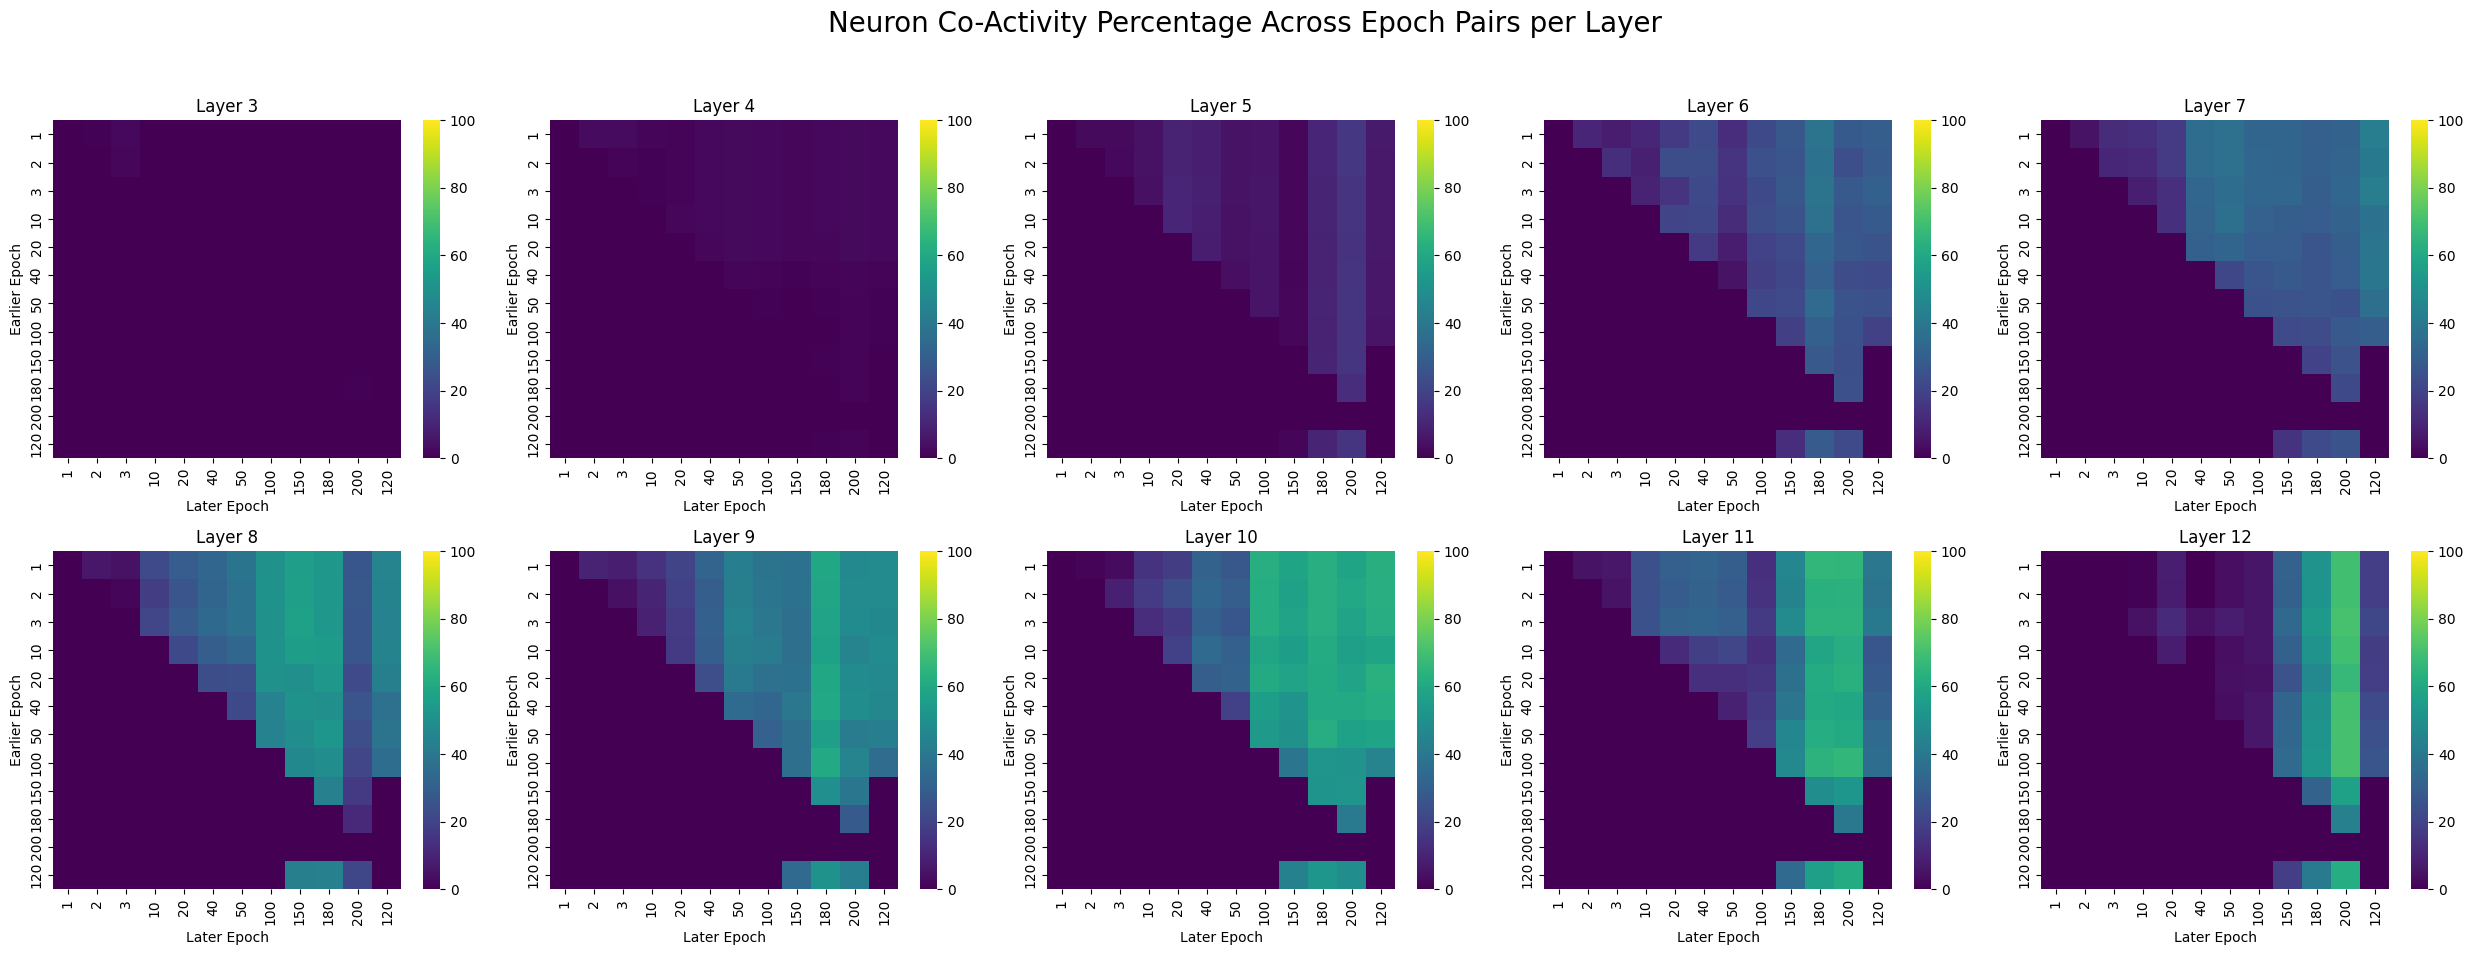


Final Result:
Percentage of neuron pairs co-active in earlier epoch but never co-active in later epoch has been saved as 'coactivity_heatmaps_all_layers.png'.


In [84]:
# Create heatmaps for each layer with 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Adjust figsize as needed
fig.suptitle('Neuron Co-Activity Percentage Across Epoch Pairs per Layer', fontsize=20)

for idx, layer_idx in enumerate(all_layers):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Extract the percentage matrix for the current layer
    data = percentages_per_layer[layer_idx]
    
    # Create a masked array to hide lower triangle (earlier >= later)
    mask = np.tril(np.ones_like(data, dtype=bool))
    masked_data = np.ma.array(data, mask=mask)
    
    # Define epoch labels
    labels = [str(epoch) for epoch in all_epochs]
    
    # Plot heatmap
    sns.heatmap(masked_data, annot=False, fmt=".2f", cmap='viridis', ax=ax, 
                xticklabels=labels, yticklabels=labels, cbar=True, 
                vmin=0, vmax=100)
    
    ax.set_title(f'Layer {layer_idx + 1}')  # Assuming layer numbering starts at 1
    ax.set_xlabel('Later Epoch')
    ax.set_ylabel('Earlier Epoch')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
plt.savefig(os.path.join(output_dir_plots, 'coactivity_heatmaps_all_layers.pdf'))
plt.show()

print("\nFinal Result:")
print("Percentage of neuron pairs co-active in earlier epoch but never co-active in later epoch has been saved as 'coactivity_heatmaps_all_layers.png'.")

In [70]:
all_epochs = other_epochs + [original_epoch]

# Select the first epoch pair with a split for analysis
earlier_epoch, later_epoch = selected_pair

# Determine number of classes
num_classes = len(spike_assignments_all_epochs[earlier_epoch])

# Analyze neuron co-activity changes using representations
percentage = analyze_neuron_coactivity_with_representations(
    representations_all_epochs=representations_all_epochs,  # Assuming pca_results_all_epochs contains 'representations'
    selected_pair=selected_pair,
    layer_idx=layer_idx,
    num_classes=num_classes
)

print(f"\nFinal Result:\nPercentage of neuron pairs co-active in Epoch {earlier_epoch} but never co-active in Epoch {later_epoch}: {percentage:.2f}%")

Analyzing layers:   0%|          | 0/12 [00:00<?, ?it/s]


Analyzing Co-Activity from Epoch 1 to Epoch 2
{1: tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), 2: tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), 3: tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
   

IndexError: tuple index out of range